#  Модель для прогнозирования оттока клиентов из банка

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

## Задачи проекта
### [Шаг 1. Загрузите и подготовьте данные. Поясните порядок действий.](#step1)

### [Шаг 2. Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.](#step2)

### [Шаг 3. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.](#step3)

### [Шаг 4. Проведите финальное тестирование.](#step4)

### [Шаг 5. Вывод](#step5)


# Этапы выполнения проекта

## Шаг 1. Откроем файлы с данными и изучим общую информацию. <a id='step1'></a>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from scikitplot.helpers import cumulative_gain_curve
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score   
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/Dmitry/Documents/Data/projects/churn/Churn.csv')


In [3]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


В датафрейме целевой признак - Exited. Кроме того, в данных есть столбцы, которые никак не влияют на уход клиента из банка. К ним относятся - RowNumber,CustomerId , Surname. При обучении моделей мы их удалим.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 976.6+ KB


In [5]:
df.duplicated().value_counts()

False    10000
dtype: int64

У некоторых клиентов не заполнен столбец с количеством недвижимости. Заполним пропуски нулями.

In [6]:
df['Tenure'] = df['Tenure'].fillna(value=0)

Удалим из датасета лишние столбцы, и проведем прямое кодирование категориальных столбцов.

In [7]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [8]:
df = pd.get_dummies(df)

In [9]:
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,1,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,1,0,0,1,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,0,1,0,0,1


Построим матрицу корреляции, чтобы понимать, какие признаки чаще всего влияют на отток клиента из банка.

<AxesSubplot:>

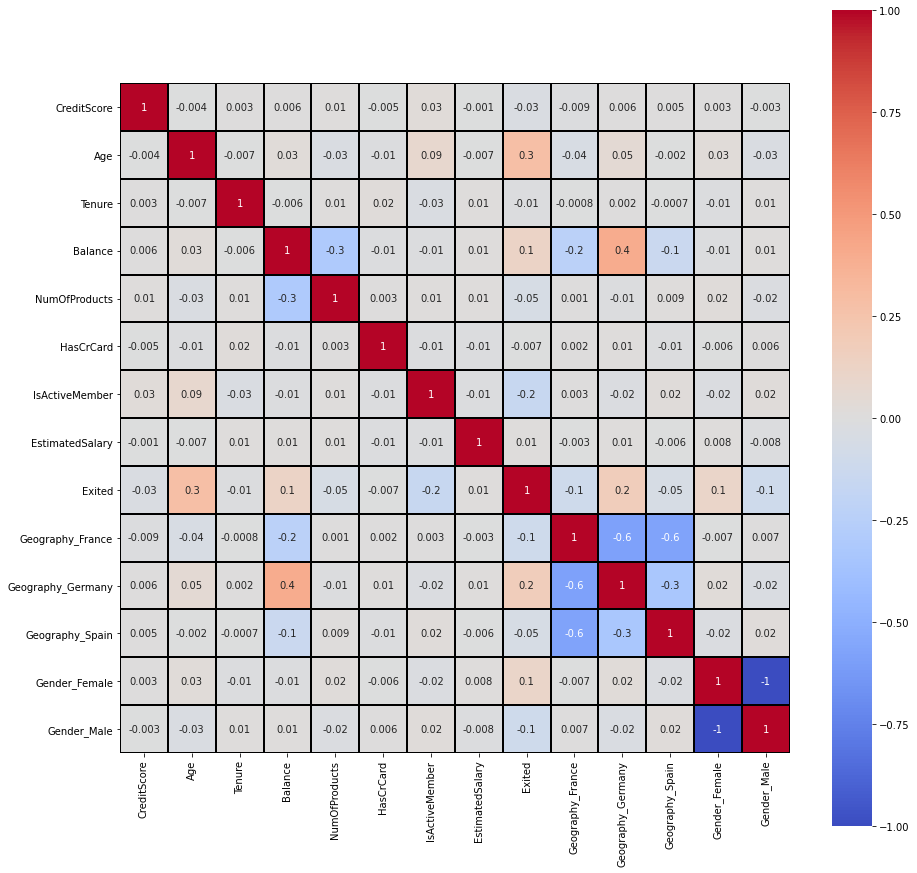

In [10]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot = True, fmt='.1g', square=True,cmap= 'coolwarm', linewidths=1, linecolor='black')

Как видно из матрицы корреляций, на отток клиентов может влиять возраст, география, и активность. Возможно для улучшения моделей стоит также отказаться от таких признаков как наличие кредитной карты?

Разделим данные на три части в соотношении 3:1:1 (обучающая, валидационная и тестовая выборки). Проверим получившиеся данные путем сложения.

In [11]:
test = df.sample(frac=0.2,random_state=42).copy()

In [12]:
len(df)

10000

In [13]:
len(test)

2000

In [14]:
train_full = df[~df.index.isin(test.index)].copy()

In [15]:
len(train_full) + len(test)

10000

In [16]:
validate = train_full.sample(frac=0.25,random_state=42).copy()
train = train_full[~train_full.index.isin(validate.index)].copy()

In [17]:
len(validate)

2000

In [18]:
len(train)

6000

In [19]:
len(train_full)

8000

In [20]:
test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6252,596,32,3.0,96709.07,2,0,0,41788.37,0,0,1,0,0,1
4684,623,43,1.0,0.00,2,1,1,146379.30,0,1,0,0,0,1
1731,601,44,4.0,0.00,2,1,0,58561.31,0,0,0,1,1,0
4742,506,59,8.0,119152.10,2,1,1,170679.74,0,0,1,0,0,1
4521,560,27,7.0,124995.98,1,1,1,114669.79,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,602,53,5.0,98268.84,1,0,1,45038.29,1,0,1,0,1,0
8285,609,25,10.0,0.00,1,0,1,109895.16,0,1,0,0,0,1
7853,730,47,7.0,0.00,1,1,0,33373.26,1,1,0,0,1,0
1095,692,29,4.0,0.00,1,1,0,76755.99,1,1,0,0,0,1


In [21]:
train.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
2,502,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0,1,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,1,0
5,645,44,8.0,113755.78,2,1,0,149756.71,1,0,0,1,0,1
6,822,50,7.0,0.00,2,1,1,10062.80,0,1,0,0,0,1
7,376,29,4.0,115046.74,4,1,0,119346.88,1,0,1,0,1,0
9,684,27,2.0,134603.88,1,1,1,71725.73,0,1,0,0,0,1
11,497,24,3.0,0.00,2,1,0,76390.01,0,0,0,1,0,1
15,616,45,3.0,143129.41,2,0,1,64327.26,0,0,1,0,0,1
16,653,58,1.0,132602.88,1,1,0,5097.67,1,0,1,0,0,1
18,587,45,6.0,0.00,1,0,0,158684.81,0,0,0,1,0,1


Отделим целевые признаки.

In [22]:
features_train = train.drop(['Exited'], axis=1)
target_train = train['Exited']
test_features = test.drop(['Exited'], axis=1)
test_target = test['Exited']
features_valid = validate.drop(['Exited'], axis=1)
target_valid = validate['Exited']

Требуют масштабирования следующие признаки - возраст, кредитный рейтинг, баланс на счете, предполагаемая зарплата. 

In [23]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [24]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])  

StandardScaler()

In [25]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

In [26]:
features_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
2,-1.558947,0.285833,8.0,1.347736,3,1,0,0.221061,1,0,0,1,0
4,2.073932,0.380172,2.0,0.800899,1,1,1,-0.389334,0,0,1,1,0
5,-0.066126,0.474512,8.0,0.612668,2,1,0,0.848582,0,0,1,0,1
6,1.781632,1.040549,7.0,-1.208881,2,1,1,-1.598326,1,0,0,0,1
7,-2.874300,-0.940581,4.0,0.633340,4,1,0,0.315917,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,1.551967,-0.940581,2.0,-1.208881,2,0,0,1.164169,1,0,0,1,0
9995,1.249227,0.002814,5.0,-1.208881,2,1,0,-0.088291,1,0,0,0,1
9996,-1.412797,-0.374544,10.0,-0.290233,1,1,1,0.006807,1,0,0,0,1
9997,0.601990,-0.280204,7.0,-1.208881,1,0,1,-1.037408,1,0,0,1,0


## Шаг 2. Обучим модели без учёта дисбаланса. <a id='step2'></a>

Исследуем баланс классов.

0    7963
1    2037
Name: Exited, dtype: int64


<AxesSubplot:>

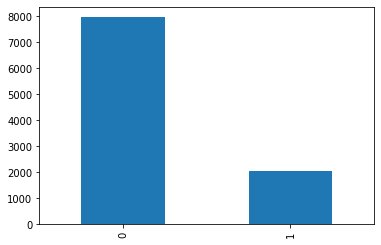

In [27]:
class_frequency = df['Exited'].value_counts()
print(class_frequency)
class_frequency.plot(kind='bar')

In [28]:
class_frequency = df['Exited'].value_counts(normalize=True)
print(class_frequency)

0    0.7963
1    0.2037
Name: Exited, dtype: float64


0    4779
1    1221
Name: Exited, dtype: int64


<AxesSubplot:>

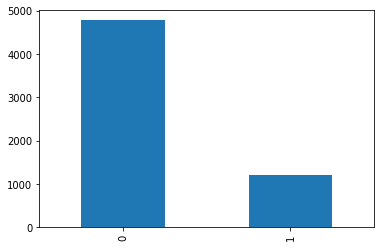

In [29]:
class_frequency = target_train.value_counts()
print(class_frequency)
class_frequency.plot(kind='bar')

In [30]:
df['Exited'].sum()/df['Exited'].count()

0.2037

In [31]:
target_train.sum()/target_train.count()

0.2035

В имеющемся датасете количество людей не покинувших банк преобладает, преобладает (почти 80%). Нам же интересны пользователи, которые покинули банк. Данных по таким пользователям - 20%.

Исследуем качество разных моделей, но заранее подготовим небольшую функцию для сбора результатов, которая будет хранить метрики depth/est, accuracy, recall, precision, f1, а на выходе будет возвращать датафрейм с данными.

In [32]:
def modelResult(target_valid, predicted_valid, depth):
    depth_list.append(depth)
    accuracy_score_list.append(accuracy_score(target_valid, predicted_valid))
    recall_score_list.append(recall_score(target_valid,predicted_valid))
    precision_score_list.append(precision_score(target_valid,predicted_valid))
    f1_score_list.append(f1_score(target_valid, predicted_valid))
    return pd.DataFrame(list(zip(depth_list, accuracy_score_list, recall_score_list, precision_score_list, f1_score_list)))

##### Обучим дерево решений

In [33]:
depth_list = []
accuracy_score_list = []
recall_score_list = []
precision_score_list = []
f1_score_list = []
for depth in range (1,20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    results = modelResult(target_valid, predicted_valid, depth)

Выведем таблицу с метриками

In [34]:
results.columns = ['depth','accuracy_score','recall_score','precision_score','f1_score']

In [35]:
results

,depth,accuracy_score,recall_score,precision_score,f1_score
0,1,0.7885,0.000000,0.000000,0.000000
1,2,0.8260,0.432624,0.628866,0.512605
2,3,0.8320,0.252955,0.842520,0.389091
3,4,0.8420,0.397163,0.733624,0.515337
4,5,0.8475,0.394799,0.773148,0.522692
5,6,0.8520,0.427896,0.770213,0.550152
6,7,0.8450,0.444444,0.714829,0.548105
7,8,0.8385,0.399527,0.710084,0.511346
8,9,0.8310,0.439716,0.648084,0.523944
9,10,0.8280,0.442080,0.633898,0.520891


<AxesSubplot:xlabel='depth'>

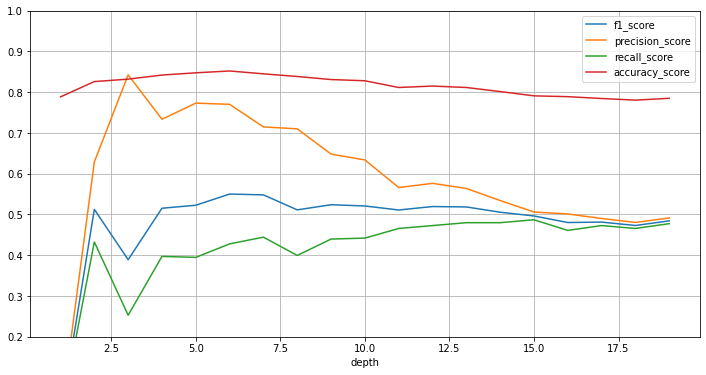

In [36]:
results.plot(x='depth', y=['f1_score','precision_score', 'recall_score', 'accuracy_score'], ylim=(0.2, 1), grid=True, figsize=(12, 6)) 

In [37]:
results['f1_score'].max() 

0.5501519756838906

In [38]:
result_tree = results.loc[results['f1_score'].idxmax()]

In [39]:
results[results['f1_score']==results['f1_score'].max()]

,depth,accuracy_score,recall_score,precision_score,f1_score
5,6,0.852,0.427896,0.770213,0.550152


In [40]:
results[results['precision_score']==results['precision_score'].max()]

,depth,accuracy_score,recall_score,precision_score,f1_score
2,3,0.832,0.252955,0.84252,0.389091


In [41]:
results[results['recall_score']==results['recall_score'].max()]

,depth,accuracy_score,recall_score,precision_score,f1_score
14,15,0.791,0.486998,0.506143,0.496386


Как видно из полученных данных, показатели Recall и Precision ведут себя по разному для модели с разной глубиной дерева. Например, наилучший показатель полноты достигается при глубине дерева 15, а наилучший показатель точности - при глубине 3. Таким образом, среднее гармоническое полноты и точности (F1) достигается при глубине 6.

##### Обучим случайное дерево

In [42]:
depth_list = []
accuracy_score_list = []
recall_score_list = []
precision_score_list = []
f1_score_list = []
for est in range(10, 201,10):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    print(est)
    model.fit(features_train,target_train) 
    predicted_valid = model.predict(features_valid)
    results = modelResult(target_valid, predicted_valid, est)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [43]:
results.columns = ['est','accuracy_score','recall_score','precision_score','f1_score']

<AxesSubplot:xlabel='est'>

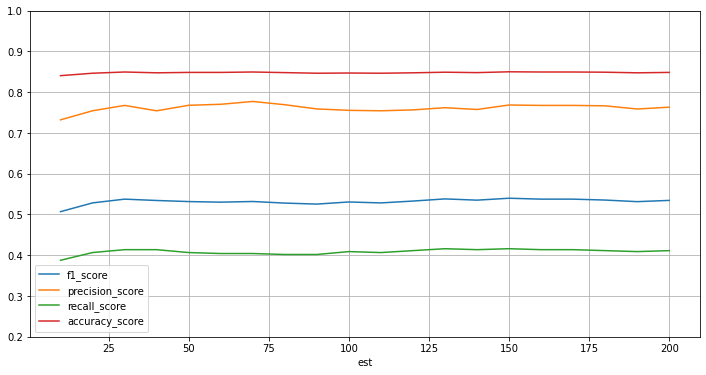

In [44]:
results.plot(x='est', y=['f1_score','precision_score', 'recall_score', 'accuracy_score'], ylim=(0.2, 1), grid=True, figsize=(12, 6)) 

In [45]:
results

,est,accuracy_score,recall_score,precision_score,f1_score
0,10,0.8405,0.387707,0.732143,0.506955
1,20,0.8465,0.406619,0.754386,0.528418
2,30,0.8495,0.413712,0.767544,0.537634
3,40,0.8475,0.413712,0.754310,0.534351
4,50,0.8485,0.406619,0.767857,0.531685
5,60,0.8485,0.404255,0.770270,0.530233
6,70,0.8495,0.404255,0.777273,0.531882
7,80,0.8480,0.401891,0.769231,0.527950
8,90,0.8465,0.401891,0.758929,0.525502
9,100,0.8470,0.408983,0.755459,0.530675


In [46]:
results.loc[results['f1_score'].idxmax()]

est                150.000000
accuracy_score       0.850000
recall_score         0.416076
precision_score      0.768559
f1_score             0.539877
Name: 14, dtype: float64

Показатель f1 для случайного дерева меньше, чем для дерева решений. Максимальные значения точности и полноты также уступают.

##### Логистическая регрессия

In [47]:
model = LogisticRegression(random_state=12345) 
model.fit(features_train,target_train) 
predicted_valid = model.predict(features_valid)

In [48]:
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid,predicted_valid))
print('Precision:', precision_score(target_valid,predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))

Accuracy: 0.8055
Recall: 0.2033096926713948
Precision: 0.6231884057971014
F1: 0.3065953654188948


In [49]:
print(confusion_matrix(target_valid, predicted_valid) )

[[1525   52]
 [ 337   86]]


Результат F1 у этой модели самый низкий.


## Шаг 3. Улучшим качество моделей. <a id='step3'></a>

### Проведем взвешивание классов

#### Логистическая регрессия

In [50]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced') 
model.fit(features_train,target_train) 
predicted_valid = model.predict(features_valid)
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid,predicted_valid))
print('Precision:', precision_score(target_valid,predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))

Accuracy: 0.726
Recall: 0.7021276595744681
Precision: 0.41307371349095967
F1: 0.5201401050788091


После взвешивания классов метрика F1 выросла с 0.306 до 0.52.

#### Рассмотрим дерево решений

In [51]:
depth_list = []
accuracy_score_list = []
recall_score_list = []
precision_score_list = []
f1_score_list = []
for depth in range (1,20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    results = modelResult(target_valid, predicted_valid, depth)

In [52]:
results.columns = ['depth','accuracy_score','recall_score','precision_score','f1_score']

In [53]:
results

,depth,accuracy_score,recall_score,precision_score,f1_score
0,1,0.6930,0.702128,0.378344,0.491722
1,2,0.6975,0.732861,0.386534,0.506122
2,3,0.6975,0.732861,0.386534,0.506122
3,4,0.7535,0.713948,0.448071,0.550593
4,5,0.7815,0.706856,0.488562,0.577778
5,6,0.7640,0.758865,0.464544,0.576302
6,7,0.7915,0.756501,0.504732,0.605487
7,8,0.7580,0.721040,0.454545,0.557587
8,9,0.7560,0.699764,0.450533,0.548148
9,10,0.7630,0.659574,0.458128,0.540698


<AxesSubplot:xlabel='depth'>

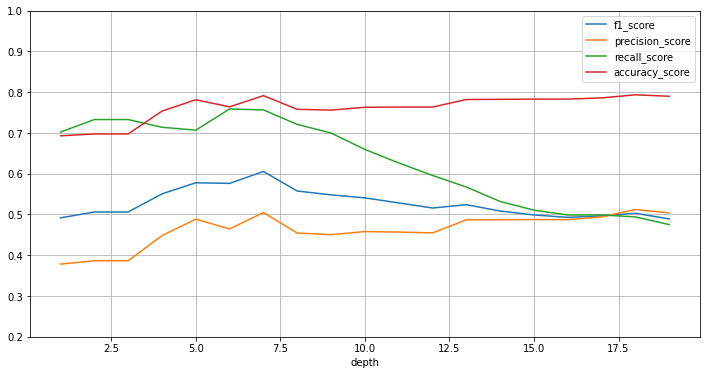

In [54]:
results.plot(x='depth', y=['f1_score','precision_score', 'recall_score', 'accuracy_score'], ylim=(0.2, 1), grid=True, figsize=(12, 6)) 

In [55]:
result_tree_balance = results.loc[results['f1_score'].idxmax()]

Сравним наилучшие показатели дерева решений со взвешиванием и без.

In [56]:
result_tree_balance

depth              7.000000
accuracy_score     0.791500
recall_score       0.756501
precision_score    0.504732
f1_score           0.605487
Name: 6, dtype: float64

In [57]:
result_tree

depth              6.000000
accuracy_score     0.852000
recall_score       0.427896
precision_score    0.770213
f1_score           0.550152
Name: 5, dtype: float64

F1 вырос с 0.55 до 0.60, а вот точность упала с 0.77 до 0.50.

#### Случайной дерево

In [58]:
depth_list = []
accuracy_score_list = []
recall_score_list = []
precision_score_list = []
f1_score_list = []
for est in range(10, 201,10):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced')
    print(est)
    model.fit(features_train,target_train) 
    predicted_valid = model.predict(features_valid)
    results = modelResult(target_valid, predicted_valid, est)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [59]:
results.columns = ['est','accuracy_score','recall_score','precision_score','f1_score']

<AxesSubplot:xlabel='est'>

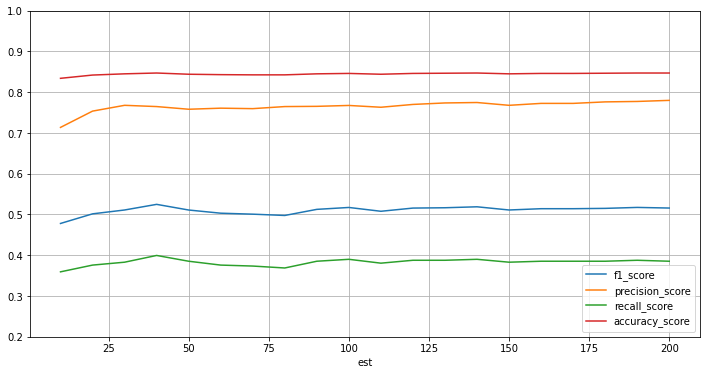

In [60]:
results.plot(x='est', y=['f1_score','precision_score', 'recall_score', 'accuracy_score'], ylim=(0.2, 1), grid=True, figsize=(12, 6)) 

In [61]:
results

,est,accuracy_score,recall_score,precision_score,f1_score
0,10,0.8340,0.359338,0.713615,0.477987
1,20,0.8420,0.375887,0.753555,0.501577
2,30,0.8450,0.382979,0.767773,0.511041
3,40,0.8470,0.399527,0.764706,0.524845
4,50,0.8440,0.385343,0.758140,0.510972
5,60,0.8430,0.375887,0.760766,0.503165
6,70,0.8425,0.373522,0.759615,0.500792
7,80,0.8425,0.368794,0.764706,0.497608
8,90,0.8450,0.385343,0.765258,0.512579
9,100,0.8460,0.390071,0.767442,0.517241


In [62]:
results.loc[results['f1_score'].idxmax()]

est                40.000000
accuracy_score      0.847000
recall_score        0.399527
precision_score     0.764706
f1_score            0.524845
Name: 3, dtype: float64

После балансировки классов f1 немного снизилась.
Таким образом, наилучший показатель f1 на текущий момент у дерева решений.

### Увеличим выборки

В данном датафрейме редкий класс - кол-во клиентов, который ушли из банка. Поэтому нам необходимо увеличить кол-во строк со значением 1 в столбце Exited. 

Разделим обучающую выборку на отрицательные и положительные объекты. 

In [63]:
target_train.value_counts()

0    4779
1    1221
Name: Exited, dtype: int64

In [64]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled



In [65]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [66]:
target_upsampled.value_counts()

1    4884
0    4779
Name: Exited, dtype: int64

Соотношение классов теперь составляет практически 50%. Пора фитить на новых данных.

In [67]:
model = LogisticRegression(random_state=123, solver='liblinear', class_weight='balanced').fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5201401050788091


In [68]:
model = RandomForestClassifier(random_state=12345, n_estimators=40, class_weight='balanced').fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5864864864864865


In [69]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7, class_weight='balanced').fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6037735849056604


Уберем атрибут class_weight='balanced'.

In [70]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7).fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6068052930056711


Видно, что результаты практически не изменились. F1 немного увеличился при удалении балансировки классов.

Попробуем изменить порог для логистическоей регресии.

In [71]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [72]:
for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid =  probabilities_one_valid > threshold 
    precision = precision_score(target_valid,predicted_valid)
    recall = recall_score(target_valid,predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1)) 

Порог = 0.00 | Точность = 0.211, Полнота = 1.000, F1 = 0.349
Порог = 0.02 | Точность = 0.211, Полнота = 1.000, F1 = 0.349
Порог = 0.04 | Точность = 0.211, Полнота = 1.000, F1 = 0.349
Порог = 0.06 | Точность = 0.211, Полнота = 0.998, F1 = 0.349
Порог = 0.08 | Точность = 0.212, Полнота = 0.998, F1 = 0.350
Порог = 0.10 | Точность = 0.215, Полнота = 0.995, F1 = 0.353
Порог = 0.12 | Точность = 0.219, Полнота = 0.993, F1 = 0.358
Порог = 0.14 | Точность = 0.223, Полнота = 0.993, F1 = 0.364
Порог = 0.16 | Точность = 0.228, Полнота = 0.986, F1 = 0.370
Порог = 0.18 | Точность = 0.235, Полнота = 0.979, F1 = 0.379
Порог = 0.20 | Точность = 0.242, Полнота = 0.972, F1 = 0.388
Порог = 0.22 | Точность = 0.251, Полнота = 0.962, F1 = 0.398
Порог = 0.24 | Точность = 0.256, Полнота = 0.936, F1 = 0.402
Порог = 0.26 | Точность = 0.266, Полнота = 0.927, F1 = 0.413
Порог = 0.28 | Точность = 0.275, Полнота = 0.915, F1 = 0.423
Порог = 0.30 | Точность = 0.286, Полнота = 0.905, F1 = 0.435
Порог = 0.32 | Точность 

Изменив порог до 0.52 мы можем достичь показателя F1 = 0.522, тем самым улучшив этот показатель с 0.520.

Попробуем изменить порог для дерева решений

In [73]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7).fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [74]:
for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid =  probabilities_one_valid > threshold 
    precision = precision_score(target_valid,predicted_valid)
    recall = recall_score(target_valid,predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1)) 

Порог = 0.00 | Точность = 0.219, Полнота = 0.972, F1 = 0.358
Порог = 0.02 | Точность = 0.244, Полнота = 0.957, F1 = 0.389
Порог = 0.04 | Точность = 0.258, Полнота = 0.957, F1 = 0.406
Порог = 0.06 | Точность = 0.258, Полнота = 0.957, F1 = 0.406
Порог = 0.08 | Точность = 0.266, Полнота = 0.948, F1 = 0.416
Порог = 0.10 | Точность = 0.270, Полнота = 0.943, F1 = 0.419
Порог = 0.12 | Точность = 0.270, Полнота = 0.943, F1 = 0.419
Порог = 0.14 | Точность = 0.286, Полнота = 0.931, F1 = 0.438
Порог = 0.16 | Точность = 0.286, Полнота = 0.931, F1 = 0.438
Порог = 0.18 | Точность = 0.320, Полнота = 0.917, F1 = 0.475
Порог = 0.20 | Точность = 0.320, Полнота = 0.915, F1 = 0.475
Порог = 0.22 | Точность = 0.324, Полнота = 0.889, F1 = 0.474
Порог = 0.24 | Точность = 0.336, Полнота = 0.882, F1 = 0.487
Порог = 0.26 | Точность = 0.336, Полнота = 0.879, F1 = 0.486
Порог = 0.28 | Точность = 0.336, Полнота = 0.879, F1 = 0.486
Порог = 0.30 | Точность = 0.376, Полнота = 0.846, F1 = 0.520
Порог = 0.32 | Точность 

#### Изменив порог до 0.54 мы увеливаем показатель F1 до 0.626. Это лучший результат

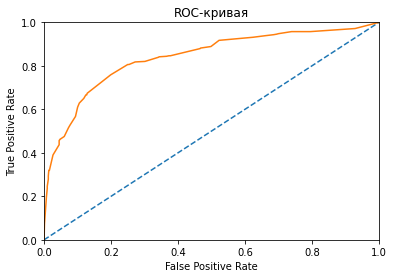

In [75]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')


plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

На графике видно, что наилучшим соотношением TPR и FPR лежит на пересечение 0,2 по оси X и 0,75 по оси Y. Подсчитаем площадь для нее.

In [76]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.8392689833615911


В целом показатель не плохой. Модель можно считать рабочей. 

## Шаг 4. Проведем финальное тестирование. <a id='step4'></a>

Напомним, что лучшая модель - дерево решений с глубиной 7. Посмотрим на тестовую выборку, убедимся что на ней нужные данные (масштабированные).

In [77]:
test_features

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6252,-0.577652,-0.657562,3.0,0.339702,2,0,0,-1.042614,0,1,0,0,1
4684,-0.295791,0.380172,1.0,-1.208881,2,1,1,0.789423,1,0,0,0,1
1731,-0.525456,0.474512,4.0,-1.208881,2,1,0,-0.748816,0,0,1,1,0
4742,-1.517190,1.889605,8.0,0.699078,2,1,1,1.215074,0,1,0,0,1
4521,-0.953467,-1.129260,7.0,0.792655,1,1,1,0.233992,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,-0.515016,1.323568,5.0,0.364679,1,0,1,-0.985688,0,1,0,1,0
8285,-0.441941,-1.317939,10.0,-1.208881,1,0,1,0.150359,1,0,0,0,1
7853,0.821215,0.757531,7.0,-1.208881,1,1,0,-1.190015,1,0,0,1,0
1095,0.424521,-0.940581,4.0,-1.208881,1,1,0,-0.430114,1,0,0,0,1


In [78]:
test_target.value_counts()

0    1607
1     393
Name: Exited, dtype: int64

In [79]:
predicted_valid = model.predict(test_features)

In [80]:
print('Accuracy:', accuracy_score(test_target, predicted_valid))
print('Recall:', recall_score(test_target,predicted_valid))
print('Precision:', precision_score(test_target,predicted_valid))
print('F1:', f1_score(test_target, predicted_valid))

Accuracy: 0.768
Recall: 0.7353689567430025
Precision: 0.4453004622496148
F1: 0.5547024952015355


Показатель F1 упал до 0.55 на тестовой выборке. Посмотрим, сколько ошибок допустила модель. Но стоит отметить, что показатель полноты довольно высокий - 0.73, который означает, что модель хорошо находит положительные объекты (а это как раз и нужно в нашей задаче).

In [81]:
test_results= confusion_matrix(test_target, predicted_valid)

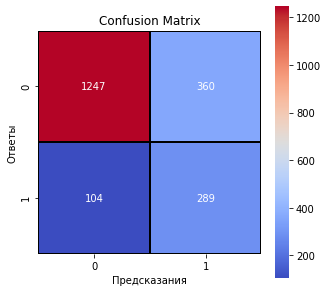

In [82]:
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(test_results, annot = True, fmt='.0f', square=True,cmap= 'coolwarm', linewidths=1, linecolor='black')
ax.set_xlabel('Предсказания');ax.set_ylabel('Ответы'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

Итого мы имеем 464 ошибки, что составляет 23% от общего числа предсказаний. Рассмотрим пороговые значения:

In [83]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7).fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(test_features)
probabilities_one_valid = probabilities_valid[:, 1]

In [84]:
for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid =  probabilities_one_valid > threshold 
    precision = precision_score(test_target,predicted_valid)
    recall = recall_score(test_target,predicted_valid)
    f1 = f1_score(test_target, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1)) 

Порог = 0.00 | Точность = 0.203, Полнота = 0.959, F1 = 0.335
Порог = 0.02 | Точность = 0.225, Полнота = 0.949, F1 = 0.363
Порог = 0.04 | Точность = 0.232, Полнота = 0.944, F1 = 0.372
Порог = 0.06 | Точность = 0.232, Полнота = 0.944, F1 = 0.372
Порог = 0.08 | Точность = 0.240, Полнота = 0.939, F1 = 0.382
Порог = 0.10 | Точность = 0.242, Полнота = 0.931, F1 = 0.384
Порог = 0.12 | Точность = 0.242, Полнота = 0.931, F1 = 0.384
Порог = 0.14 | Точность = 0.254, Полнота = 0.908, F1 = 0.397
Порог = 0.16 | Точность = 0.254, Полнота = 0.908, F1 = 0.397
Порог = 0.18 | Точность = 0.285, Полнота = 0.893, F1 = 0.433
Порог = 0.20 | Точность = 0.286, Полнота = 0.891, F1 = 0.433
Порог = 0.22 | Точность = 0.294, Полнота = 0.880, F1 = 0.441
Порог = 0.24 | Точность = 0.304, Полнота = 0.870, F1 = 0.450
Порог = 0.26 | Точность = 0.306, Полнота = 0.870, F1 = 0.453
Порог = 0.28 | Точность = 0.306, Полнота = 0.870, F1 = 0.453
Порог = 0.30 | Точность = 0.336, Полнота = 0.837, F1 = 0.479
Порог = 0.32 | Точность 

Как видно, при пороге 0.6 мы достигаем максимального показателя F1 = 0.593.

Построим ROC кривую и расчитаем AUC-ROC.

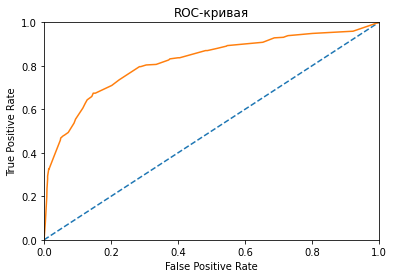

In [85]:
fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_valid) 

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')


plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

In [86]:
auc_roc = roc_auc_score(test_target, probabilities_one_valid)

print(auc_roc)

0.8183804633355026


Показатель auc_roc немного уменьшился, а наилучшее соотношение fpr и tpr сдвинулось.

## Шаг 5. Вывод. <a id='step5'></a>

Перед нами стояла задача построить модель, которая прогнозирует, уйдет клиент из банка в ближайшее время или нет. В имеющемся датафрейме были лишние признаки, которые никак не влияли на построение моделей, и поэтому были удалены. На этапе обработки данных проведено масштабирование признаков, и кодирование категориальных признаков.
Во время изучения баланс классов выявлено, что в датасете имелось лишь 20% объектов с положительным результатом, а остальные - с нулевым. Поэтому в процессе поиска оптимальной модели мы произвели увеличение выборки.
Наилучшая модель - дерево решений с глубиной 7. На валидационной выборке показатель F1 составлял 0,626, а на тестовой опустился до 0,593 при пороге 0,6. Показатель auc_roc также немного уменьшился - с 0.839 до 0.818. Полнота не изменилась на тестовой и валидационной выборках, и составляет 0.674, но точность упала с 0.584 до 0.529.
В целом были получены неплохие метрики, которые можно использовать для скоринга клиентов.